<a href="https://colab.research.google.com/github/szendiagoston/TabNet/blob/main/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U scikit-learn
!pip install pytorch-tabnet
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=827bde2b880f92c42fbfc034fb9784985c51335d6f3b2ea3967c9962442c8aac
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
from pytorch_tabnet.pretraining import TabNetPretrainer

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import scipy

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import sklearn

In [ ]:
sklearn.__version__

'1.2.2'

In [ ]:
torch.cuda.get_device_capability()

(7, 5)

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

import torch
torch.__version__

'2.1.0+cu118'

In [ ]:
from zipfile import ZipFile

from google.colab import files

In [ ]:
upload = files.upload()
zip_file = ZipFile('archive.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [ ]:
url = "https://github.com/szendiagoston/TabNet/raw/main/archive.zip"
import urllib.request as request
request.urlretrieve(url,'archive.zip')

zip_file = ZipFile('archive.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [ ]:
dfs['train.csv']

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


In [ ]:
[col for col in dfs['train.csv'].columns]

['policy_id',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'airbags',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'displacement',
 'cylinder',
 'transmission_type',
 'gear_box',
 'steering_type',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'ncap_rating',
 'is_claim']

In [ ]:
[sum(dfs['train.csv'][col].isnull()) for col in dfs['train.csv'].columns] #nincs hiányzó adat

dfs['train.csv'].isna().any() #van-e hiányzó adat? -> nincs

policy_id                           False
policy_tenure                       False
age_of_car                          False
age_of_policyholder                 False
area_cluster                        False
population_density                  False
make                                False
segment                             False
model                               False
fuel_type                           False
max_torque                          False
max_power                           False
engine_type                         False
airbags                             False
is_esc                              False
is_adjustable_steering              False
is_tpms                             False
is_parking_sensors                  False
is_parking_camera                   False
rear_brakes_type                    False
displacement                        False
cylinder                            False
transmission_type                   False
gear_box                          

In [ ]:
dfs['train.csv'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [ ]:
dfs['train.csv'].describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


In [ ]:
train = dfs['train.csv'].drop(columns = ['policy_id']) #id nem kell

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 10: #Levettem 200-ról 10-re -> kicsit javított: best valid auc 0,66161
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        #train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    #else:
        #train.fillna(train.loc[train_indices, col].mean(), inplace=True)

area_cluster 22
make 5
segment 6
model 11
fuel_type 3
max_torque 9
max_power 9
engine_type 11
airbags 3
is_esc 2
is_adjustable_steering 2
is_tpms 2
is_parking_sensors 2
is_parking_camera 2
rear_brakes_type 2
displacement 9
cylinder 2
transmission_type 2
gear_box 2
steering_type 3
turning_radius 9
length 9
is_front_fog_lights 2
is_rear_window_wiper 2
is_rear_window_washer 2
is_rear_window_defogger 2
is_brake_assist 2
is_power_door_locks 2
is_central_locking 2
is_power_steering 2
is_driver_seat_height_adjustable 2
is_day_night_rear_view_mirror 2
is_ecw 2
is_speed_alert 2
ncap_rating 5
is_claim 2


In [ ]:
import sklearn.model_selection as ms

In [ ]:
ms.train_test_split? #HF

SyntaxError: ignored

In [ ]:
target = 'is_claim'

if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.9, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
#test_indices = train[train.Set=="test"].index

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
cat_idxs #plicy_tenure kivételével mind az...

[3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]

grouped_features???

In [ ]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

#X_test = train[features].values[test_indices]
#y_test = train[target].values[test_indices]

In [ ]:
# TabNetPretrainer
EMB_DIM = 3
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=EMB_DIM,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
unsupervised_model.fit(
    X_train=smote_X,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 243.41975| val_0_unsup_loss_numpy: 2.074810028076172|  0:00:05s
epoch 5  | loss: 0.76014 | val_0_unsup_loss_numpy: 0.7010700106620789|  0:00:28s
epoch 10 | loss: 0.59878 | val_0_unsup_loss_numpy: 0.5291500091552734|  0:00:51s
epoch 15 | loss: 0.22541 | val_0_unsup_loss_numpy: 0.14565999805927277|  0:01:14s
epoch 20 | loss: 0.09059 | val_0_unsup_loss_numpy: 0.07524000108242035|  0:01:37s
epoch 25 | loss: 0.14861 | val_0_unsup_loss_numpy: 0.08764000236988068|  0:01:59s
epoch 30 | loss: 0.06629 | val_0_unsup_loss_numpy: 0.05646999925374985|  0:02:21s
epoch 35 | loss: 0.05975 | val_0_unsup_loss_numpy: 0.051920000463724136|  0:02:46s
epoch 40 | loss: 0.05936 | val_0_unsup_loss_numpy: 0.05772000178694725|  0:03:10s

Early stopping occurred at epoch 40 with best_epoch = 35 and best_val_0_unsup_loss_numpy = 0.051920000463724136


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_train.mean() #smote kell -> kell, mert csak 6% a kárigények aránya.

0.06446785132421476

In [ ]:
aug = ClassificationSMOTE(p=0.2)
y_train.mean() #nem  változik, mert this will average a percentage p of the elements in the batch with other elements. The target will stay unchanged and keep the value of the most important row in the mix.
#Ez alapján nem értem, milyen p kéne...
#Ettől nem igazán javult: best valid auc 0,6251 lett...

0.06372056901483152

In [ ]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":EMB_DIM,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2), #Ha 0.2-re veszem, akkor romlik kicsit: best valid auc 0,60606
                 "scheduler_params":{"step_size":50, #elég 10? # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 #"grouped_features" : grouped_features
                 "seed":2023
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
unsupervised_model.device

device(type='cuda')

In [ ]:
os = SMOTE(random_state = 0)
smote_X, smote_y = os.fit_resample(X_train, y_train)
smote_y.mean() #fele-fele arány lett

0.5

In [ ]:
# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices
sparse_X_train = scipy.sparse.csr_matrix(smote_X)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X_valid)  # Create a CSR matrix from X_valid

# Fitting the model
clf.fit(
    X_train=sparse_X_train, y_train=smote_y,
    eval_set=[(sparse_X_train, smote_y), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128, #túl magas? -> nem
    num_workers=0,
    weights=1,
    drop_last=False,
    #augmentations=aug, #aug, None
    from_unsupervised=unsupervised_model
)

#nagyobb patience vagy tanulási ráta segíthet -> Nem igazán, fentebb írom learning rate-nél.

#előtanítás segíthet -> nem, best valid auc 0,66416, de valószínűleg tovább kéne csinálni a pretraininget és/vagy a patience-t, mert ott max epochnál állt meg, itt meg max patience-nél.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.72792 | train_auc: 0.51717 | train_accuracy: 0.51203 | valid_auc: 0.53216 | valid_accuracy: 0.64235 |  0:00:27s
epoch 1  | loss: 0.6827  | train_auc: 0.544   | train_accuracy: 0.53012 | valid_auc: 0.54318 | valid_accuracy: 0.55423 |  0:00:55s
epoch 2  | loss: 0.66945 | train_auc: 0.56884 | train_accuracy: 0.53697 | valid_auc: 0.55597 | valid_accuracy: 0.55906 |  0:01:22s
epoch 3  | loss: 0.66394 | train_auc: 0.59818 | train_accuracy: 0.55704 | valid_auc: 0.57053 | valid_accuracy: 0.57976 |  0:01:50s
epoch 4  | loss: 0.65644 | train_auc: 0.641   | train_accuracy: 0.59976 | valid_auc: 0.5892  | valid_accuracy: 0.45163 |  0:02:16s
epoch 5  | loss: 0.64837 | train_auc: 0.64664 | train_accuracy: 0.6127  | valid_auc: 0.60941 | valid_accuracy: 0.55096 |  0:02:43s
epoch 6  | loss: 0.64297 | train_auc: 0.66219 | train_accuracy: 0.61319 | valid_auc: 0.6029  | valid_accuracy: 0.60873 |  0:03:10s
epoch 7  | loss: 0.63849 | train_auc: 0.66143 | train_accuracy: 0.60596 | valid_auc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Comparing to logit model
Használt oldalak:

*   https://learn.theprogrammingfoundation.org/getting_started/intro_data_science/module4/?gclid=CjwKCAiAxreqBhAxEiwAfGfndJ7ktwBSs5bRoYVpD5I0F4FLMqFK-xSyzT5eA7abKVk3KR7GTfnBHBoC5wEQAvD_BwE
*   https://www.datacamp.com/tutorial/understanding-logistic-regression-python?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720824&utm_adgroupid=157156376311&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=679431869741&utm_targetid=dsa-2218886984100&utm_loc_interest_ms=&utm_loc_physical_ms=9063089&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p2_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na-fawnov23&gad_source=1&gclid=CjwKCAiAxreqBhAxEiwAfGfndHQWaA8-5hNGA_EHbWsssS46TH0d2DkTjISQPbY951OHwzIxGxm1cxoC0HcQAvD_BwE
*   https://medium.com/@rithpansanga/logistic-regression-for-feature-selection-selecting-the-right-features-for-your-model-410ca093c5e0



In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import math
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

In [ ]:
os = SMOTE(random_state = 0)
smote_X, smote_y = os.fit_resample(X_train, y_train)
smote_y.mean() #fele-fele arány lett

0.5

In [ ]:
logreg = LogisticRegression(random_state = 0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[5415,    0],
       [ 384,    0]])

Text(0.5, 427.9555555555555, 'Predicted label')

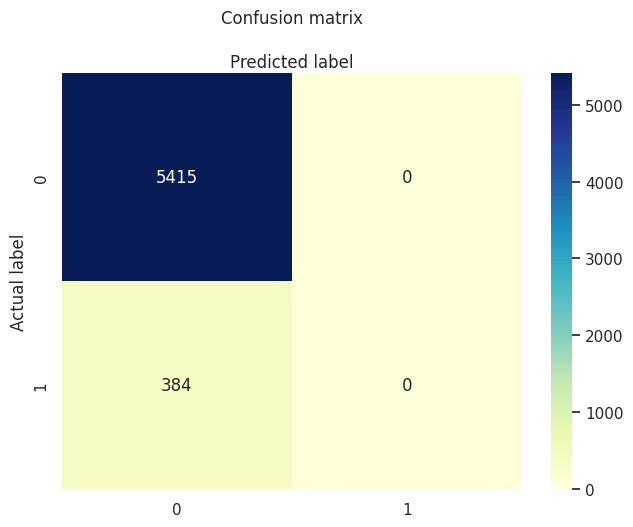

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
# Use RFE to select the top 10 features
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(smote_X, smote_y)

# Print the selected features
print(rfe.support_)

[ True False False  True  True  True False False False  True  True False
 False False False False False False False False False False False False
  True False  True  True  True False False False False False False False
 False False False False False False]


In [ ]:
X_train[:,1]

array([0.05, 0.02, 0.02, ..., 0.05, 0.14, 0.02])

In [ ]:
smote_X[:, rfe.support_]

array([[5.15873590e-01, 0.00000000e+00, 4.99000000e+03, ...,
        1.51500000e+03, 1.47500000e+03, 1.18500000e+03],
       [6.72618514e-01, 1.10000000e+01, 2.70030000e+04, ...,
        1.51500000e+03, 1.47500000e+03, 1.18500000e+03],
       [8.41110256e-01, 1.50000000e+01, 4.07600000e+03, ...,
        1.51500000e+03, 1.47500000e+03, 1.18500000e+03],
       ...,
       [7.44380507e-02, 3.00000000e+00, 3.47910000e+04, ...,
        1.79000000e+03, 1.63500000e+03, 1.72000000e+03],
       [4.94906864e-01, 4.00000000e+00, 5.41000000e+03, ...,
        1.47500000e+03, 1.82500000e+03, 1.51000000e+03],
       [2.75978945e-01, 2.00000000e+00, 6.10800000e+03, ...,
        1.74500000e+03, 1.50000000e+03, 1.41000000e+03]])

In [ ]:
logreg = LogisticRegression(random_state = 0)
logreg.fit(smote_X[:, rfe.support_], smote_y)
y_pred_rfe = logreg.predict(X_valid[:, rfe.support_])
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[2365, 3050],
       [ 172,  212]])

In [ ]:
smote_X == smote_X[:, rfe.support_]

<ipython-input-74-5520262a1333>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  smote_X == smote_X[:, rfe.support_]


False

In [ ]:
all(y_pred_rfe == y_pred) #Nem használt semmit a változószelekció... TabNet jobb, de logit még rosszabb, mint a véletlen, úgyhogy nem csoda...

True

In [ ]:
auc = metrics.roc_auc_score(y_valid, y_pred)
auc

0.4944165512465375

In [ ]:
acc = logreg.score(X_valid, y_valid)
acc

0.44438696326952926

# Statisztikai módszerek a biztosításban tárgyhoz

## Adatbeolvasás (nem kell tudni a pontos fájlnevet)

In [ ]:
!pip install rpy2

In [ ]:
# Using R inside python
import rpy2
import rpy2.robjects as robjects

In [ ]:
robjects.r["install.packages"]("insuranceData")

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpf4SyUy/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7e99cbc25e80> [RTYPES.NILSXP]

In [ ]:
!pip install rdata

In [ ]:
import rdata #Elég innen, de miért?

In [ ]:
parsed = rdata.parser.parse_file("/usr/local/lib/R/site-library/insuranceData/data/dataCar.rda")

In [ ]:
converted = rdata.conversion.convert(parsed)

In [ ]:
converted["dataCar"]

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,X_OBSTAT_
1,1.06,0.303901,0,0,0.000000,HBACK,3,F,C,2,01101 0 0 0
2,1.03,0.648871,0,0,0.000000,HBACK,2,F,A,4,01101 0 0 0
3,3.26,0.569473,0,0,0.000000,UTE,2,F,E,2,01101 0 0 0
4,4.14,0.317591,0,0,0.000000,STNWG,2,F,D,2,01101 0 0 0
5,0.72,0.648871,0,0,0.000000,HBACK,4,F,C,2,01101 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...
67852,1.07,0.654346,0,0,0.000000,SEDAN,2,M,A,6,01101 0 0 0
67853,1.23,0.908966,0,0,0.000000,SEDAN,4,M,C,3,01101 0 0 0
67854,1.93,0.312115,0,0,0.000000,STNWG,4,M,C,3,01101 0 0 0
67855,0.97,0.320329,1,1,7646.769989,HBACK,3,F,C,2,01101 0 0 0


## Adatbeolvasás (kell tudni a pontos fájlnevet, de épp ezért reprodukálható)

In [4]:
!wget https://cran.r-project.org/src/contrib/insuranceData_1.0.tar.gz

!tar -xvzf insuranceData_1.0.tar.gz

--2023-12-05 11:25:22--  https://cran.r-project.org/src/contrib/insuranceData_1.0.tar.gz
Resolving cran.r-project.org (cran.r-project.org)... 137.208.57.37
Connecting to cran.r-project.org (cran.r-project.org)|137.208.57.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 598456 (584K) [application/x-gzip]
Saving to: ‘insuranceData_1.0.tar.gz’

insuranceData_1.0.t 100%[===================>] 584.43K  --.-KB/s    in 0.1s    

2023-12-05 11:25:23 (4.74 MB/s) - ‘insuranceData_1.0.tar.gz’ saved [598456/598456]

insuranceData/
insuranceData/NAMESPACE
insuranceData/data/
insuranceData/data/Thirdparty.rda
insuranceData/data/AutoClaims.rda
insuranceData/data/SingaporeAuto.rda
insuranceData/data/WorkersComp.rda
insuranceData/data/dataOhlsson.rda
insuranceData/data/dataCar.rda
insuranceData/data/AutoBi.rda
insuranceData/data/ClaimsLong.rda
insuranceData/data/AutoCollision.rda
insuranceData/data/IndustryAuto.rda
insuranceData/MD5
insuranceData/DESCRIPTION
insuranceData/man

In [5]:
!pip install rdata

In [6]:
import rdata #Elég innen, de miért?

In [7]:
parsed = rdata.parser.parse_file("insuranceData/data/dataCar.rda")

In [8]:
converted = rdata.conversion.convert(parsed)

In [9]:
converted["dataCar"]

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,X_OBSTAT_
1,1.06,0.303901,0,0,0.000000,HBACK,3,F,C,2,01101 0 0 0
2,1.03,0.648871,0,0,0.000000,HBACK,2,F,A,4,01101 0 0 0
3,3.26,0.569473,0,0,0.000000,UTE,2,F,E,2,01101 0 0 0
4,4.14,0.317591,0,0,0.000000,STNWG,2,F,D,2,01101 0 0 0
5,0.72,0.648871,0,0,0.000000,HBACK,4,F,C,2,01101 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...
67852,1.07,0.654346,0,0,0.000000,SEDAN,2,M,A,6,01101 0 0 0
67853,1.23,0.908966,0,0,0.000000,SEDAN,4,M,C,3,01101 0 0 0
67854,1.93,0.312115,0,0,0.000000,STNWG,4,M,C,3,01101 0 0 0
67855,0.97,0.320329,1,1,7646.769989,HBACK,3,F,C,2,01101 0 0 0


# Kárszám

## Adatelőkészítés - Preprocessing

In [ ]:
dataCar = converted["dataCar"]

In [ ]:
dataCar = dataCar.drop(columns=["X_OBSTAT_", "clm", "claimcst0"]) #Az X_OBSTAT_ változó nem kell, a többi pedig nem ismert a szerződés megkötésekor.
dataCar

,veh_value,exposure,numclaims,veh_body,veh_age,gender,area,agecat
1,1.06,0.303901,0,HBACK,3,F,C,2
2,1.03,0.648871,0,HBACK,2,F,A,4
3,3.26,0.569473,0,UTE,2,F,E,2
4,4.14,0.317591,0,STNWG,2,F,D,2
5,0.72,0.648871,0,HBACK,4,F,C,2
...,...,...,...,...,...,...,...,...
67852,1.07,0.654346,0,SEDAN,2,M,A,6
67853,1.23,0.908966,0,SEDAN,4,M,C,3
67854,1.93,0.312115,0,STNWG,4,M,C,3
67855,0.97,0.320329,1,HBACK,3,F,C,2


In [ ]:
features, target = dataCar.drop('numclaims', axis = 1), dataCar['numclaims']

In [ ]:
display(features.head(5))

,veh_value,exposure,veh_body,veh_age,gender,area,agecat
1,1.06,0.303901,HBACK,3,F,C,2
2,1.03,0.648871,HBACK,2,F,A,4
3,3.26,0.569473,UTE,2,F,E,2
4,4.14,0.317591,STNWG,2,F,D,2
5,0.72,0.648871,HBACK,4,F,C,2


In [ ]:
# Megnézzük, hogy van-e hiányzó érték.

display(features.isna().sum()) #Nincs.

veh_value    0
exposure     0
veh_body     0
veh_age      0
gender       0
area         0
agecat       0
dtype: int64

In [ ]:
import numpy as np
from sklearn import preprocessing

In [ ]:
# Külön gyűjtjük a kategorikus változókat.

nunique = features.nunique()
types = features.dtypes

cat_limit = np.mean([nunique[col] for col in features.columns])
print(cat_limit)

categorical_columns = []
categorical_dims =  {}
for col in features.columns:
    if types[col] == 'object' or nunique[col] < cat_limit:
        print(col, features[col].nunique())
        l_enc = LabelEncoder()
        #features[col] = features[col].fillna("VV_likely")
        features[col] = l_enc.fit_transform(features[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    #else:
        #train.fillna(train.loc[train_indices, col].mean(), inplace=True)

200.0
veh_body 13
veh_age 4
gender 2
area 6
agecat 6


In [ ]:
def col_name(a, b):
  if a == "feature":
    return a+b
  i = int(a[1:])
  #print(a, b)
  return f"{categorical_columns[i]}_{b}"

In [ ]:
one_hot_encoder = preprocessing.OneHotEncoder(
    #categories = 'auto', # Az adatból határozza meg, hogy milyen kategóriák vannak.
    #drop = 'if_binary', # Kétértékű változókat binárisan kódoljon el, 2 < n értékű változókat n hosszó vektorként.
    sparse_output = False, # numpy arrayt adjon vissza.
    feature_name_combiner = col_name #"concat" #Így látnám, milyen kategóriák lettek, de nem működik.
)

encoded_features = one_hot_encoder.fit_transform(features[categorical_columns]) # Transzformáljuk az adathalmazt.

In [ ]:
one_hot_encoder.categories_ #Jól működik.

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([0, 1, 2, 3]),
 array([0, 1]),
 array([0, 1, 2, 3, 4, 5]),
 array([0, 1, 2, 3, 4, 5])]

In [ ]:
one_hot_encoder.get_feature_names_out()

array(['veh_body_0', 'veh_body_1', 'veh_body_2', 'veh_body_3',
       'veh_body_4', 'veh_body_5', 'veh_body_6', 'veh_body_7',
       'veh_body_8', 'veh_body_9', 'veh_body_10', 'veh_body_11',
       'veh_body_12', 'veh_age_0', 'veh_age_1', 'veh_age_2', 'veh_age_3',
       'gender_0', 'gender_1', 'area_0', 'area_1', 'area_2', 'area_3',
       'area_4', 'area_5', 'agecat_0', 'agecat_1', 'agecat_2', 'agecat_3',
       'agecat_4', 'agecat_5'], dtype=object)

In [ ]:
#Hogy láthatnám, melyik oszlop miből lett?
pd.DataFrame(encoded_features, columns = one_hot_encoder.get_feature_names_out()) #Azért nem 13 + 4 + 2 + 6 + 6 = 31, mert volt egy bináris változó, amit 1 oszlopként kódolt.

,veh_body_0,veh_body_1,veh_body_2,veh_body_3,veh_body_4,veh_body_5,veh_body_6,veh_body_7,veh_body_8,veh_body_9,...,area_2,area_3,area_4,area_5,agecat_0,agecat_1,agecat_2,agecat_3,agecat_4,agecat_5
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
67852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
67853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
67854,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
numerical_columns = [col for col in features.columns if col not in categorical_columns]
numerical_columns

['veh_value', 'exposure']

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[numerical_columns])
pd.DataFrame(scaled_features, columns = numerical_columns) #Hogy láthatnám az eredeti oszlopneveket?

,veh_value,exposure
0,-0.594928,-0.568058
1,-0.619820,0.621395
2,1.230461,0.347632
3,1.960616,-0.520858
4,-0.877033,0.621395
...,...,...
67851,-0.586631,0.640276
67852,-0.453875,1.518205
67853,0.126930,-0.539738
67854,-0.669603,-0.511418


In [ ]:
scaled_features

array([[-0.59492792, -0.56805819],
       [-0.61981958,  0.6213953 ],
       [ 1.23046082,  0.34763219],
       ...,
       [ 0.12693036, -0.53973787],
       [-0.66960291, -0.51141755],
       [-0.62811681, -0.76630044]])

In [ ]:
# Adat konkatenálása.
X = np.concatenate([scaled_features, encoded_features], axis = 1) # összerakjuk a különböző módon előfeldolgozott értékeket
print(type(X), X.shape)

<class 'numpy.ndarray'> (67856, 33)


In [ ]:
# train-test vágás
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_test = train_test_split(X, target, test_size = 0.2, random_state = 2)

In [ ]:
# Define categorical features for categorical embeddings.

cat_idxs = [ i for i, f in enumerate(features.columns) if f in categorical_columns] #Itt csak véletlenül jó, hogy featuresben és X-ben ugyanannyiadik oszlopok kategorikusak, nem?

cat_dims = [ categorical_dims[f] for i, f in enumerate(features.columns) if f in categorical_columns]

In [ ]:
cat_idxs

[2, 3, 4, 5, 6]

Na jóóó! Szerintem nem kell one-hot-encoding, mert meg kell adni, mely változók kategorikusak. Tehát innen prepocessing újra!

In [ ]:
features[numerical_columns] = scaled_features #Helyettesítem a numerikus oszlopokat a sztenderdizáltjukkal.
features

,veh_value,exposure,veh_body,veh_age,gender,area,agecat
1,-0.594928,-0.568058,3,2,0,2,1
2,-0.619820,0.621395,3,1,0,0,3
3,1.230461,0.347632,12,1,0,4,1
4,1.960616,-0.520858,10,1,0,3,1
5,-0.877033,0.621395,3,3,0,2,1
...,...,...,...,...,...,...,...
67852,-0.586631,0.640276,9,1,1,0,5
67853,-0.453875,1.518205,9,3,1,2,2
67854,0.126930,-0.539738,10,3,1,2,2
67855,-0.669603,-0.511418,3,2,0,2,1


In [ ]:
# train-test vágás
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, target.values.astype(np.int64).reshape(-1, 1), test_size = 0.2, random_state = 2)

train_indices = X_train.index
valid_indices = X_valid.index
#test_indices = train[train.Set=="test"].index

In [ ]:
# Define categorical features for categorical embeddings.

cat_idxs = [ i for i, f in enumerate(features.columns) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features.columns) if f in categorical_columns]

## Pre-training

In [ ]:
# Network parameters

from pytorch_tabnet.pretraining import TabNetPretrainer

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# Self Supervised Training

max_epochs = 100 if not os.getenv("CI", False) else 2 # 1000

unsupervised_model.fit(
    X_train=X_train.values,
    eval_set=[X_valid.values],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 2.63419 | val_0_unsup_loss_numpy: 1.0313299894332886|  0:00:04s
epoch 5  | loss: 0.9189  | val_0_unsup_loss_numpy: 0.9593499898910522|  0:00:19s
epoch 10 | loss: 0.87616 | val_0_unsup_loss_numpy: 0.9469199776649475|  0:00:35s
epoch 15 | loss: 0.86071 | val_0_unsup_loss_numpy: 0.9099400043487549|  0:00:50s

Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_unsup_loss_numpy = 0.9069300293922424


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Ez után sok mindent kiírat még, de lényegi részhez ez nem kell.

## Regresszió

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

In [ ]:
cat_dims == categorical_dims

False

In [ ]:
# Network parameters

cat_emb_dim = [5, 4, 3, 6, 2] # define your embedding sizes - here is just a random choice; note: cat_emb_dim and cat_dims must be lists of same length

clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
X_train = X_train.values
X_valid = X_valid.values

#y_train = np.array(y_train).reshape(-1, 1)
#y_valid = np.array(y_valid).reshape(-1, 1)

In [ ]:
y_valid.values.astype(np.int64).reshape(-1, 1)

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
# Training

max_epochs = 100 if not os.getenv("CI", False) else 2

# Kell SMOTE?
#from pytorch_tabnet.augmentations import RegressionSMOTE
#aug = RegressionSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
#    augmentations=aug, #aug
    from_unsupervised=unsupervised_model
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.18255 | train_rmsle: 0.18383 | train_mae: 0.13065 | train_rmse: 0.27847 | train_mse: 0.07755 | valid_rmsle: 0.18965 | valid_mae: 0.13528 | valid_rmse: 0.28956 | valid_mse: 0.08384 |  0:00:07s
epoch 1  | loss: 0.07677 | train_rmsle: 0.18288 | train_mae: 0.13322 | train_rmse: 0.27424 | train_mse: 0.07521 | valid_rmsle: 0.18837 | valid_mae: 0.13749 | valid_rmse: 0.28478 | valid_mse: 0.0811  |  0:00:13s
epoch 2  | loss: 0.07662 | train_rmsle: 0.18658 | train_mae: 0.14958 | train_rmse: 0.27509 | train_mse: 0.07567 | valid_rmsle: 0.19161 | valid_mae: 0.15382 | valid_rmse: 0.28515 | valid_mse: 0.08131 |  0:00:18s
epoch 3  | loss: 0.07722 | train_rmsle: 0.1814  | train_mae: 0.11574 | train_rmse: 0.27696 | train_mse: 0.0767  | valid_rmsle: 0.18732 | valid_mae: 0.12026 | valid_rmse: 0.28776 | valid_mse: 0.08281 |  0:00:23s
epoch 4  | loss: 0.07614 | train_rmsle: 0.18267 | train_mae: 0.12943 | train_rmse: 0.27774 | train_mse: 0.07714 | valid_rmsle: 0.1886  | valid_mae: 0.13413 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Kárnagyság

## Adatelőkészítés - Preprocessing

In [10]:
dataCar = converted["dataCar"]

In [11]:
dataCar = dataCar.drop(columns=["X_OBSTAT_", "clm", "numclaims"]) #Az X_OBSTAT_ változó nem kell, a többi pedig nem ismert a szerződés megkötésekor.
dataCar

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
1,1.06,0.303901,0.000000,HBACK,3,F,C,2
2,1.03,0.648871,0.000000,HBACK,2,F,A,4
3,3.26,0.569473,0.000000,UTE,2,F,E,2
4,4.14,0.317591,0.000000,STNWG,2,F,D,2
5,0.72,0.648871,0.000000,HBACK,4,F,C,2
...,...,...,...,...,...,...,...,...
67852,1.07,0.654346,0.000000,SEDAN,2,M,A,6
67853,1.23,0.908966,0.000000,SEDAN,4,M,C,3
67854,1.93,0.312115,0.000000,STNWG,4,M,C,3
67855,0.97,0.320329,7646.769989,HBACK,3,F,C,2


In [12]:
features, target = dataCar.drop('claimcst0', axis = 1), dataCar['claimcst0']

In [13]:
# Megnézzük, hogy van-e hiányzó érték.

display(features.isna().sum()) #Nincs.

veh_value    0
exposure     0
veh_body     0
veh_age      0
gender       0
area         0
agecat       0
dtype: int64

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 1 to 67856
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   veh_value  67856 non-null  float64 
 1   exposure   67856 non-null  float64 
 2   veh_body   67856 non-null  category
 3   veh_age    67856 non-null  Int32   
 4   gender     67856 non-null  category
 5   area       67856 non-null  category
 6   agecat     67856 non-null  Int32   
dtypes: Int32(2), category(3), float64(2)
memory usage: 1.9 MB


In [15]:
# Külön gyűjtjük a kategorikus változókat.

nunique = features.nunique()
types = features.dtypes

cat_limit = np.mean([nunique[col] for col in features.columns])
print(cat_limit)

categorical_columns = []
categorical_dims =  {}
for col in features.columns:
    if types[col] == 'object' or nunique[col] < cat_limit:
        print(col, features[col].nunique())
        l_enc = LabelEncoder()
        #features[col] = features[col].fillna("VV_likely")
        features[col] = l_enc.fit_transform(features[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    #else:
        #train.fillna(train.loc[train_indices, col].mean(), inplace=True)

200.0
veh_body 13
veh_age 4
gender 2
area 6
agecat 6


In [16]:
numerical_columns = [col for col in features.columns if col not in categorical_columns]
numerical_columns

['veh_value', 'exposure']

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [45]:
# train-test vágás
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, target.values.astype(np.int64).reshape(-1, 1), test_size = 0.2, random_state = 2)

#train_indices = X_train.index
#valid_indices = X_valid.index
#test_indices = train[train.Set=="test"].index

In [18]:
X_train.isna().sum()

veh_value    0
exposure     0
veh_body     0
veh_age      0
gender       0
area         0
agecat       0
dtype: int64

In [19]:
from sklearn.preprocessing import StandardScaler

In [46]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])
X_train_scaled = scaler.transform(X_train[numerical_columns])
#X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_columns)

In [47]:
X_valid_scaled = scaler.transform(X_valid[numerical_columns])
#X_valid_scaled = pd.DataFrame(X_valid_scaled, columns = numerical_columns)

In [48]:
# Helyettesítjük a numerikus oszlopokat a sztenderdizált változattal.

X_train[numerical_columns] = X_train_scaled
X_valid[numerical_columns] = X_valid_scaled

In [49]:
X_valid

,veh_value,exposure,veh_body,veh_age,gender,area,agecat
54265,-0.278947,-0.905714,9,2,0,3,4
53686,0.184534,-0.556632,9,1,1,1,3
20934,0.863202,-0.452851,10,2,0,2,2
63792,0.383169,0.584960,10,2,0,0,2
498,0.118322,1.509555,4,3,1,0,0
...,...,...,...,...,...,...,...
56753,4.613260,-1.339708,10,0,0,3,2
6890,-0.684493,-1.537835,3,2,0,1,1
3373,1.202537,1.443512,7,0,1,2,4
27679,3.188884,-1.330273,10,0,1,5,1


In [50]:
X_train.isna().sum()

veh_value    0
exposure     0
veh_body     0
veh_age      0
gender       0
area         0
agecat       0
dtype: int64

In [51]:
# Define categorical features for categorical embeddings.

cat_idxs = [ i for i, f in enumerate(features.columns) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features.columns) if f in categorical_columns]

## Pre-training

In [52]:
# Network parameters

from pytorch_tabnet.pretraining import TabNetPretrainer

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [53]:
X_train.isna().sum() #Miért lesz Na?

veh_value    0
exposure     0
veh_body     0
veh_age      0
gender       0
area         0
agecat       0
dtype: int64

In [56]:
# Self Supervised Training

max_epochs = 100 if not os.getenv("CI", False) else 2 # 1000

unsupervised_model.fit(
    X_train=X_train.values,
    eval_set=[X_valid.values],
    max_epochs=max_epochs , patience=20,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 2.60959 | val_0_unsup_loss_numpy: 1.0256199836730957|  0:00:02s
epoch 5  | loss: 0.91184 | val_0_unsup_loss_numpy: 0.9761300086975098|  0:00:15s
epoch 10 | loss: 0.87288 | val_0_unsup_loss_numpy: 1.0647200345993042|  0:00:28s
epoch 15 | loss: 0.85809 | val_0_unsup_loss_numpy: 1.0163899660110474|  0:00:41s
epoch 20 | loss: 0.85668 | val_0_unsup_loss_numpy: 1.0349600315093994|  0:00:53s

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_unsup_loss_numpy = 0.9504299759864807


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Regresszió

In [55]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

In [64]:
# Network parameters

cat_emb_dim = [5, 4, 3, 6, 2] # define your embedding sizes - here is just a random choice; note: cat_emb_dim and cat_dims must be lists of same length

tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":cat_emb_dim,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":30, # how to use learning rate scheduler
                                     "gamma":0.1},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 #"grouped_features" : grouped_features
}

In [65]:
clf = TabNetRegressor(**tabnet_params)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [58]:
X_train = X_train.values
X_valid = X_valid.values

In [66]:
# Training

max_epochs = 100 if not os.getenv("CI", False) else 2

# Kell SMOTE?
#from pytorch_tabnet.augmentations import RegressionSMOTE
#aug = RegressionSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
#    augmentations=aug, #aug
    from_unsupervised=unsupervised_model
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: cat_emb_dim changed from [5, 4, 3, 6, 2] to [3, 3, 3, 3, 3]
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 1112585.87094| train_rmsle: 3.17391 | train_mae: 157.41805| train_rmse: 1052.32443| train_mse: 1107386.70742| valid_rmsle: 3.18393 | valid_mae: 166.6001| valid_rmse: 1097.46175| valid_mse: 1204422.28207|  0:00:04s
epoch 1  | loss: 1101624.02504| train_rmsle: 4.31833 | train_mae: 212.35343| train_rmse: 1047.11842| train_mse: 1096456.98746| valid_rmsle: 4.31467 | valid_mae: 220.9536| valid_rmse: 1092.28282| valid_mse: 1193081.75595|  0:00:08s
epoch 2  | loss: 1095485.14555| train_rmsle: 4.72648 | train_mae: 251.83182| train_rmse: 1046.34101| train_mse: 1094829.51792| valid_rmsle: 4.72292 | valid_mae: 260.29944| valid_rmse: 1091.37522| valid_mse: 1191099.86027|  0:00:11s
epoch 3  | loss: 1094741.76181| train_rmsle: 4.63852 | train_mae: 240.09671| train_rmse: 1046.08004| train_mse: 1094283.45544| valid_rmsle: 4.63542 | valid_mae: 248.68395| valid_rmse: 1091.06122| valid_mse: 1190414.58702|  0:00:16s
epoch 4  | loss: 1094456.57025| train_rmsle: 4.65995 | train_mae: 245.2649

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [91]:
clf.save_model("model.pth")

Successfully saved model at model.pth.zip


'model.pth.zip'

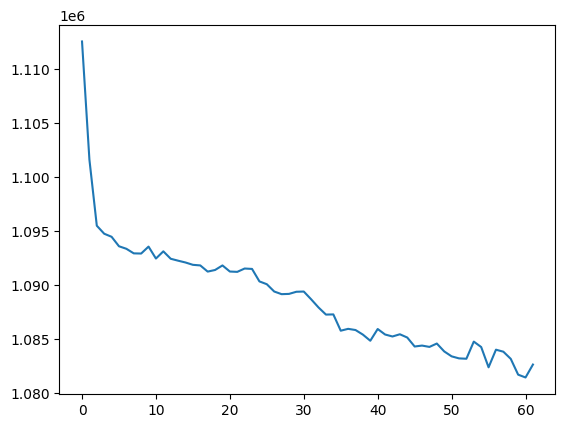

In [67]:
plt.plot(clf.history["loss"])

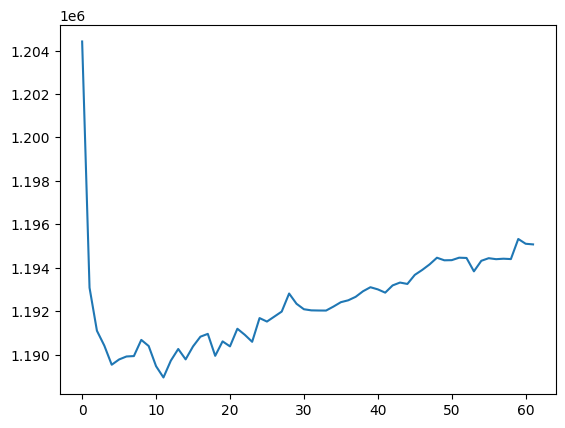

In [68]:
plt.plot(clf.history["valid_mse"])

In [69]:
y_valid_pred = clf.predict(X_valid)

In [83]:
y_valid_pred.sum()/y_valid.sum()

0.9318071950863123

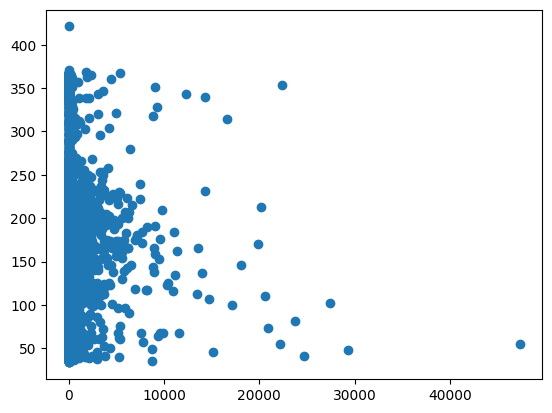

In [70]:
plt.plot(y_valid, y_valid_pred, "o")

(array([3.333e+03, 2.190e+02, 6.300e+01, 2.300e+01, 6.000e+00, 5.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  200. ,  5772.2, 11344.4, 16916.6, 22488.8, 28061. , 33633.2,
        39205.4, 44777.6, 50349.8, 55922. ]),
 <BarContainer object of 10 artists>)

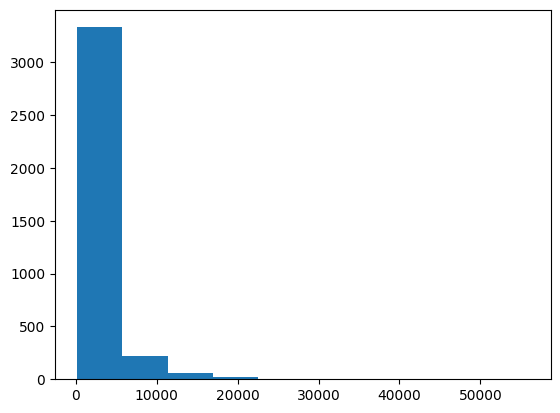

In [81]:
plt.hist(y_train[y_train>0])

(array([187., 219., 139., 144., 110.,  88.,  48.,  22.,  11.,   3.]),
 array([2.30103   , 2.53840944, 2.77578888, 3.01316832, 3.25054776,
        3.4879272 , 3.72530665, 3.96268609, 4.20006553, 4.43744497,
        4.67482441]),
 <BarContainer object of 10 artists>)

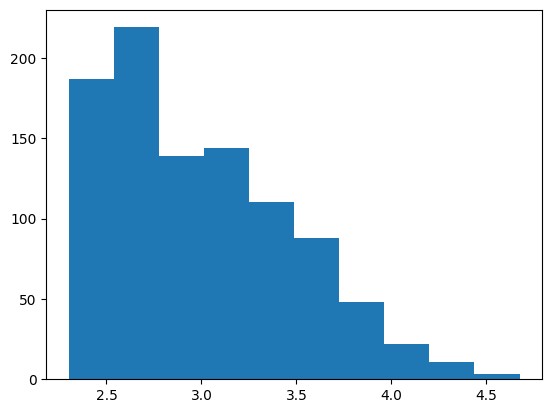

In [74]:
plt.hist(np.log10(y_valid[y_valid>0]))

(array([784., 868., 504., 513., 403., 271., 193.,  83.,  27.,   7.]),
 array([2.30103   , 2.54568527, 2.79034054, 3.03499581, 3.27965108,
        3.52430635, 3.76896162, 4.01361689, 4.25827216, 4.50292743,
        4.7475827 ]),
 <BarContainer object of 10 artists>)

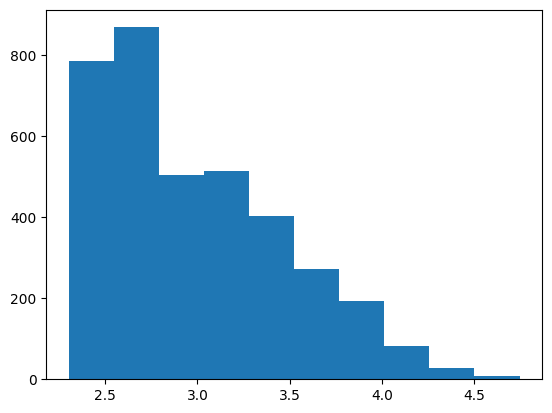

In [79]:
plt.hist(np.log10(y_train[y_train>0]))